# Lineær regression - Kan vi estimere antallet af linjer

- **Problem:** Kan jeg med ML estimere antallet af linjer en FED overskrift giver anledning til? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et lineært problem
- **Succes er** Jeg vil undersøge om en simpel model kan finde sammenhængen. Jeg håber på det bedste, men er skeptisk, for jeg kan ikke selv se et klart mønster ...
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data?
- **Optimering vs generalisering** Den får vi se på ...
- **Tuning hyper pametre** Den får vi se på ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Evaluering af forsøg

- indledningsvis lavede jeg en fejl, da jeg ikke fik fjernet "activation" fra sidste lag
- første model med dense16, dropout og epocs=10 ender med mae_val=1.9
- prover at fjerne dense16 og dropout, og sætter epocs=20, det giver mae_val=1.9. Den kan ligesom ikke komme længere ned ...
- prøver at øge epocs=40. mae_validation staller efter <5 epocs, mens mae_train faktisk bliver bedre og bedre. Hmmm, det virker ikke som om den rigtigt har fundet sammenhængen

### Konklusion
Desværre er der ikke skyggen af en lige linje, som ville indikere en vis sammenhæng mennen predictions, og det der skulle findes. Selv hvor der slet ikke er noget problem (kun 1 linje) viser den en masse gange mange linjer predicted ...:
![title](EstLines01.png)




In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 80000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [3]:
# TOKENIZER - laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Fandt %s unikke tokens.' % len(word_index))

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fandt 21158 unikke tokens.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
NumLines_train = np.asarray(NumLines_train).astype('float32')
NumLines_test = np.asarray(NumLines_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(NumLines_train.shape)
print(NumLines_test.shape)

(80000, 10000)
(20867, 10000)
(80000,)
(20867,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
#model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 40
history = model.fit(data_train, NumLines_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/40
64000/64000 [==============================] - 15s 228us/step - loss: 24.9639 - mean_absolute_error: 2.2116 - val_loss: 20.2056 - val_mean_absolute_error: 2.0118
Epoch 2/40
64000/64000 [==============================] - 10s 151us/step - loss: 21.0956 - mean_absolute_error: 1.9370 - val_loss: 18.1885 - val_mean_absolute_error: 1.9232
Epoch 3/40
64000/64000 [==============================] - 9s 140us/step - loss: 19.4218 - mean_absolute_error: 1.8895 - val_loss: 17.1290 - val_mean_absolute_error: 1.9366
Epoch 4/40
64000/64000 [==============================] - 8s 120us/step - loss: 18.5058 - mean_absolute_error: 1.8895 - val_loss: 16.6055 - val_mean_absolute_error: 1.9493
Epoch 5/40
64000/64000 [==============================] - 8s 120us/step - loss: 17.9416 - mean_absolute_error: 1.8923 - val_loss: 16.3214 - val_mean_absolute_error: 1.9567
Epoch 6/40
64000/64000 [==============================] - 8s 124us/step - loss: 17.5582 

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

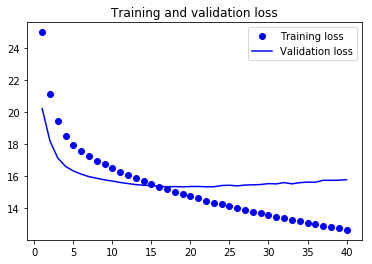

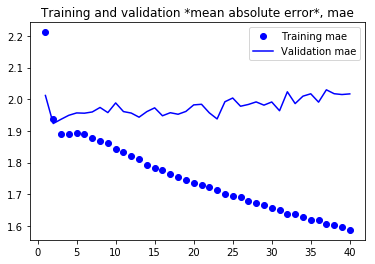

In [9]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae      = history.history['mean_absolute_error']
val_mae  = history.history['val_mean_absolute_error']

epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation *mean absolute error*, mae')
plt.legend()
plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [10]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

2.2903
2.1472
2.2041
1.8795
5.8322
0.3943
2.4423
3.0702
1.6193


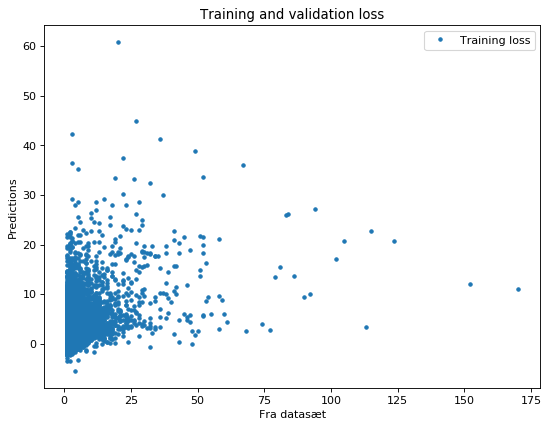

In [11]:
# plotter predictions vs 'hvad den faktisk skal være'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(NumLines_test, predictions, '.', label='Training loss')       # bo = "blue dot"
plt.xlabel('Fra datasæt')
plt.ylabel('Predictions')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
print('linje  SkalVære  Prediction  Tekst')
for i in range(1,9000):
    if NumLines_test[i] > 29:
        PrtStr = (('%4.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.1f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje  SkalVære  Prediction  Tekst
 426        113         3.5  Materiel. Passager melder at noget ryger fra toget.
1186         32         5.1  K -12 u Mst.. Signalfejl Trg..
1432         41        15.7  Vendinger og kørsel Vest
1567         55         6.0  Disponering på Kysten
1579         41         1.9  Kl 09:02 - der holder et sj tog I cph spor 1 -- IP 530
1760         38        18.4  Sporskiftefejl i Hellerup spor 1 udkørsels skiftet (laskebrud i/ved sp
1884         54         9.4  Politi: Fundet en mistænkelig kuffert og Tgf vil ikke køre længere. Tg
2056         53         8.7  Spsk.fejl i KLV
2066         36         6.9  Øvrige BDK: L -37
2076         40         8.3  Har påkørt en tabt puffer fra et G tog på vej ud af RG .
2085         32         4.2  Materielmangel. Vi mangler kraftigt togsæt i Od og Fa.
2218         39        14.6  NY PLAN FOR RESTEN AF DAGEN Vi starter på 25xx systemet og 45 system
2379         94        27.1  Strategi ifb. med køreledningsnedfald Ky, lagt